In [279]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [281]:
%%R

require('tidyverse')
require('DescTools')

In [282]:
df = pd.read_csv('plants_merged_eji.csv')
df.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY_x,StateDesc,STATEABBR,LOCATION,...,latitude,STATE,COUNTY_y,TRACT,contains_energy_source,Technology_Category,Category_Number,fossil_fuels,renewables,energy_category_numeric
0,1,1,20804,140000US01001020804,1001020804,1001020804,Autauga County,Alabama,AL,Census Tract 208.04; Autauga County; Alabama,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0
1,1,3,10706,140000US01003010706,1003010706,1003010706,Baldwin County,Alabama,AL,Census Tract 107.06; Baldwin County; Alabama,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0
2,1,3,11503,140000US01003011503,1003011503,1003011503,Baldwin County,Alabama,AL,Census Tract 115.03; Baldwin County; Alabama,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0
3,1,3,11604,140000US01003011604,1003011604,1003011604,Baldwin County,Alabama,AL,Census Tract 116.04; Baldwin County; Alabama,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0
4,1,5,950100,140000US01005950100,1005950100,1005950100,Barbour County,Alabama,AL,Census Tract 9501; Barbour County; Alabama,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0


In [283]:
df.shape

(88364, 195)

In [284]:
pd.set_option('display.max_rows', None)

In [285]:
df.dtypes

STATEFP                                 int64
COUNTYFP                                int64
TRACTCE                                 int64
AFFGEOID                               object
GEOID                                   int64
GEOID_2020                              int64
COUNTY_x                               object
StateDesc                              object
STATEABBR                              object
LOCATION                               object
E_TOTPOP                              float64
M_TOTPOP                              float64
E_DAYPOP                              float64
SPL_EJI                               float64
RPL_EJI                               float64
SPL_SER                               float64
RPL_SER                               float64
SPL_EJI_CBM                           float64
RPL_EJI_CBM                           float64
E_MINRTY                              float64
EPL_MINRTY                            float64
SPL_SVM_DOM1                      

In [286]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_POV200, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_POV200, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.765548   0.047121 -79.912   <2e-16 ***
E_POV200    -0.002502   0.001369  -1.828   0.0675 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17533  on 85948  degrees of freedom
Residual deviance: 17530  on 85947  degrees of freedom
  (2415 observations deleted due to missingness)
AIC: 17534

Number of Fisher Scoring iterations: 6



## Existence of a fossil fuel power plant does seem correlated with cancer rates, though R-squared is small

In [287]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_CANCER, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_CANCER, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.709828   0.073671  -63.93   <2e-16 ***
E_CANCER     0.103940   0.007957   13.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17553  on 86049  degrees of freedom
Residual deviance: 17395  on 86048  degrees of freedom
  (2314 observations deleted due to missingness)
AIC: 17399

Number of Fisher Scoring iterations: 6



In [288]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.00897732 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2314 rows containing missing values or values outside the scale range
(`geom_point()`). 



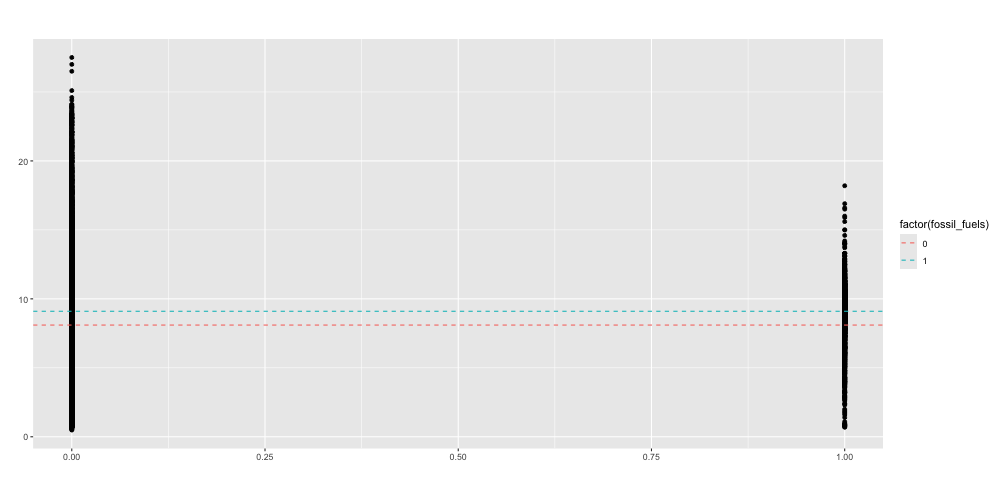

In [289]:
%%R -w 1000

library(dplyr)
library(ggplot2)

# Calculate medians by fossil_fuels group
medians <- df %>%
    group_by(fossil_fuels) %>%
    summarise(med_y = median(E_CANCER, na.rm = TRUE))

ggplot(df) +
    aes(x = fossil_fuels, y = E_CANCER) +
    geom_point() +
    geom_hline(data = medians, aes(yintercept = med_y, color = factor(fossil_fuels)), 
               linetype = "dashed", show.legend = TRUE) +
    labs(title = str_wrap("", width = 75), 
         subtitle = "", x = "", y = "") 

## This is confirmed in the below T-Test that shows the mean of cancer rates are higher in tracts with fossil fuel powerplants, with a small p-value

In [290]:
%%R

fossil_fuels <- df %>% filter(fossil_fuels == 1)
no_ff <- df %>% filter(fossil_fuels == 0)

t.test(fossil_fuels$E_CANCER, no_ff$E_CANCER)


	Welch Two Sample t-test

data:  fossil_fuels$E_CANCER and no_ff$E_CANCER
t = 15.96, df = 1929.7, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7249776 0.9281146
sample estimates:
mean of x mean of y 
 8.789552  7.963006 



R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2314 rows containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 2: Removed 9 rows containing missing values or values outside the scale range
(`geom_segment()`). 



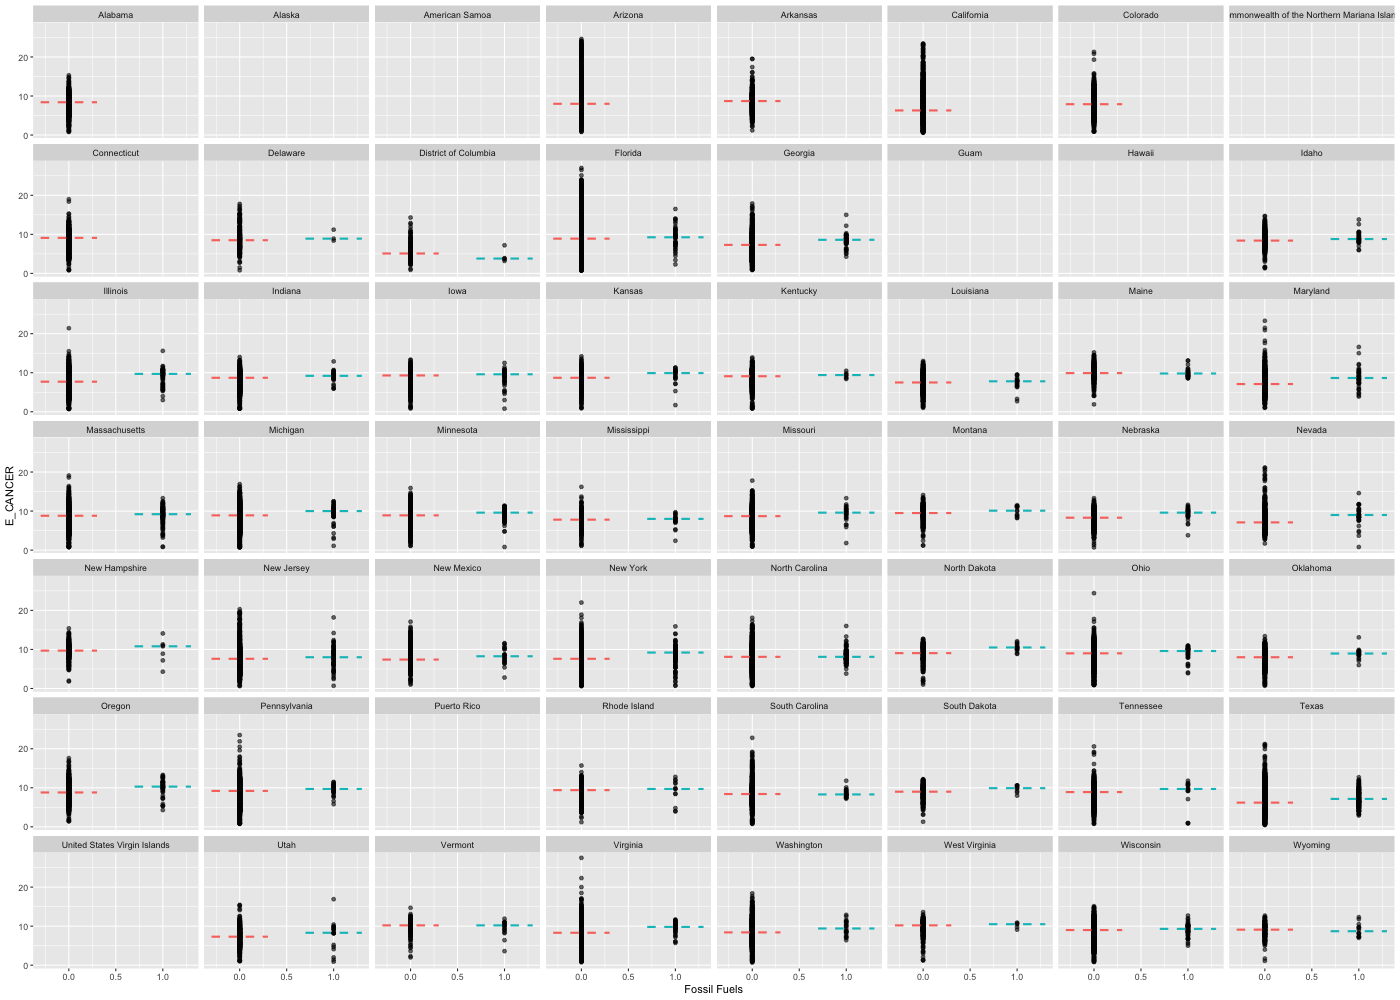

In [291]:
%%R -w 1400 -h 1000

library(dplyr)
library(ggplot2)

# Calculate medians by State and fossil_fuels
medians <- df %>%
    group_by(StateDesc, fossil_fuels) %>%
    summarise(med_cancer = median(E_CANCER, na.rm = TRUE), .groups = "drop")

# Add start and end x values for the segments (jitter around the x position)
medians <- medians %>%
    mutate(x_start = fossil_fuels - 0.3,
           x_end = fossil_fuels + 0.3)

ggplot(df) + 
    aes(x = fossil_fuels, y = E_CANCER) + 
    geom_point(alpha = 0.6) +
    geom_segment(data = medians,
                 aes(x = x_start, xend = x_end,
                     y = med_cancer, yend = med_cancer,
                     color = factor(fossil_fuels)),
                 linetype = "dashed", linewidth = 1, show.legend = FALSE) +
    facet_wrap(~StateDesc) +
    labs(x = "Fossil Fuels", y = "E_CANCER")


In [301]:
pivot = df.pivot_table(
    index='StateDesc',
    columns='fossil_fuels',
    values='E_CANCER',
    aggfunc='median'
)

In [304]:
pivot.dtypes

fossil_fuels
0    float64
1    float64
dtype: object

In [305]:
pivot['difference'] = pivot[1] - pivot[0]

In [307]:
pivot.sort_values(by='difference', ascending=False)

fossil_fuels,0,1,difference
StateDesc,,,
Illinois,7.70,9.70,2.00
Nevada,7.10,9.00,1.90
New York,7.60,9.20,1.60
Maryland,7.10,8.65,1.55
Virginia,8.30,9.80,1.50
Oregon,8.80,10.30,1.50
North Dakota,9.05,10.50,1.45
Georgia,7.30,8.60,1.30
Nebraska,8.30,9.60,1.30


### In Illinois, Nevada, New York and Maryland, there is the largest difference in cancer rates in places with fossil fuel powerplants to places without

In [308]:
%%R

library(dplyr)
library(tidyr)

# Exclude Puerto Rico from the dataset
valid_states <- df %>%
  filter(StateDesc != "Puerto Rico") %>%
  group_by(StateDesc, fossil_fuels) %>%
  summarise(n = n(), .groups = "drop") %>%
  pivot_wider(names_from = fossil_fuels, values_from = n, names_prefix = "ff_") %>%
  filter(!is.na(ff_0), !is.na(ff_1)) %>%
  filter(ff_1 >= 5) %>%  # Ensure at least 5 fossil_fuels == 1
  pull(StateDesc)

In [293]:
%%R

library(dplyr)
library(broom)

# Run t-tests and calculate means for each fossil_fuels group
ttests <- df %>%
  filter(StateDesc %in% valid_states) %>%
  group_by(StateDesc) %>%
  summarise(
    ttest = list(t.test(E_CANCER ~ fossil_fuels)),  # Run t-test
    mean_ff_0 = mean(E_CANCER[fossil_fuels == 0], na.rm = TRUE),  # Mean for fossil_fuels == 0
    mean_ff_1 = mean(E_CANCER[fossil_fuels == 1], na.rm = TRUE),  # Mean for fossil_fuels == 1
    .groups = "drop"
  ) %>%
  mutate(
    p.value = map_dbl(ttest, ~.x$p.value),  # Extract p-value
    ttest = NULL  # Remove ttest list column
  )

# Print the t-test results with means
print(ttests, n = 38)


Error in `summarise()`:
ℹ In argument: `ttest = list(t.test(E_CANCER ~ fossil_fuels))`.
ℹ In group 4: `StateDesc = "Hawaii"`.
Caused by error in `t.test.formula()`:
! grouping factor must have exactly 2 levels
Run `rlang::last_trace()` to see where the error occurred.

Error in summarise(., ttest = list(t.test(E_CANCER ~ fossil_fuels)), mean_ff_0 = mean(E_CANCER[fossil_fuels ==  : 
  
ℹ In group 4: `StateDesc = "Hawaii"`.
Caused by error in `t.test.formula()`:
! grouping factor must have exactly 2 levels


RInterpreterError: Failed to parse and evaluate line '\nlibrary(dplyr)\nlibrary(broom)\n\n# Run t-tests and calculate means for each fossil_fuels group\nttests <- df %>%\n  filter(StateDesc %in% valid_states) %>%\n  group_by(StateDesc) %>%\n  summarise(\n    ttest = list(t.test(E_CANCER ~ fossil_fuels)),  # Run t-test\n    mean_ff_0 = mean(E_CANCER[fossil_fuels == 0], na.rm = TRUE),  # Mean for fossil_fuels == 0\n    mean_ff_1 = mean(E_CANCER[fossil_fuels == 1], na.rm = TRUE),  # Mean for fossil_fuels == 1\n    .groups = "drop"\n  ) %>%\n  mutate(\n    p.value = map_dbl(ttest, ~.x$p.value),  # Extract p-value\n    ttest = NULL  # Remove ttest list column\n  )\n\n# Print the t-test results with means\nprint(ttests, n = 38)\n'.
R error message: 'Error in summarise(., ttest = list(t.test(E_CANCER ~ fossil_fuels)), mean_ff_0 = mean(E_CANCER[fossil_fuels ==  : \n  \nℹ In group 4: `StateDesc = "Hawaii"`.\nCaused by error in `t.test.formula()`:\n! grouping factor must have exactly 2 levels'

### The means appear significantly different in Illinois, New York, North Dakota, Pennsylvania, Texas and Massachusetts.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2314 rows containing missing values or values outside the scale range
(`geom_point()`). 



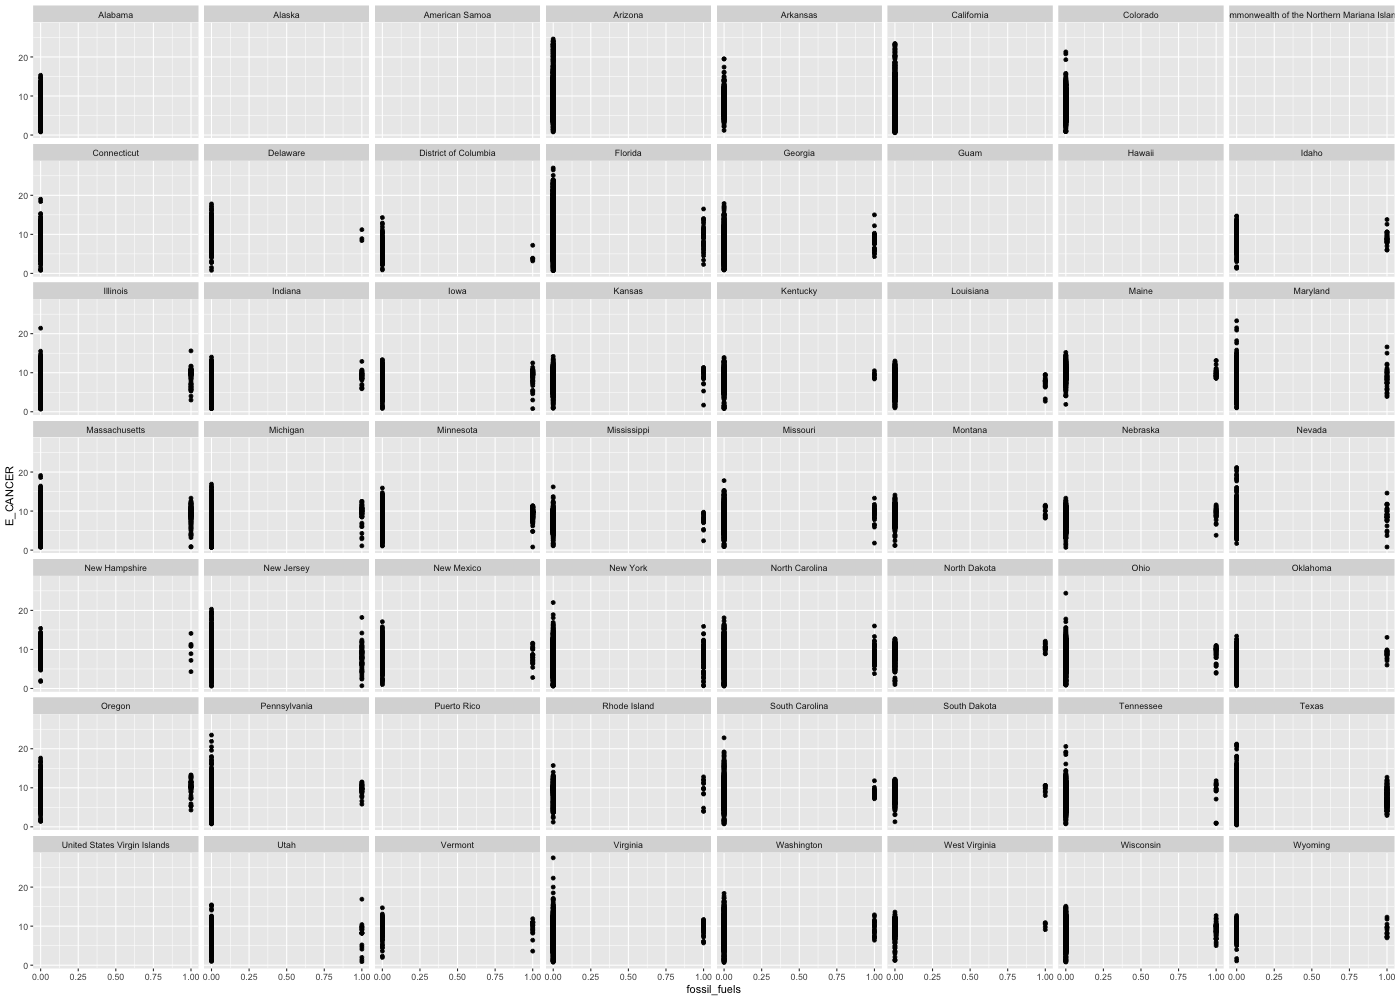

In [309]:
%%R -w 1400 -h 1000

ggplot(df) + 
	aes(x=fossil_fuels, y=E_CANCER) + 
	geom_point() +
    facet_wrap(~StateDesc)

In [310]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_IMPWTR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_IMPWTR, family = "binomial", data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.44640    0.03479  -99.06   <2e-16 ***
E_IMPWTR    -0.89234    0.06685  -13.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17733  on 86659  degrees of freedom
Residual deviance: 17546  on 86658  degrees of freedom
  (1704 observations deleted due to missingness)
AIC: 17550

Number of Fisher Scoring iterations: 7



In [311]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.01051738 


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 1704 rows containing missing values or values outside the scale range
(`geom_point()`). 



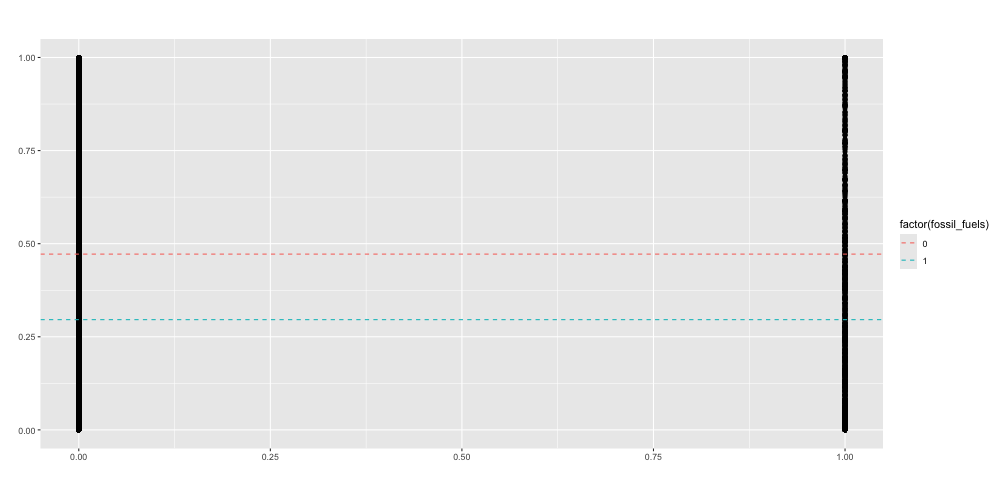

In [312]:
%%R -w 1000

library(dplyr)
library(ggplot2)

# Calculate medians by fossil_fuels group
medians <- df %>%
    group_by(fossil_fuels) %>%
    summarise(med_y = median(E_IMPWTR, na.rm = TRUE))

ggplot(df) +
    aes(x = fossil_fuels, y = E_IMPWTR) +
    geom_point() +
    geom_hline(data = medians, aes(yintercept = med_y, color = factor(fossil_fuels)), 
               linetype = "dashed", show.legend = TRUE) +
    labs(title = str_wrap("", width = 75), 
         subtitle = "", x = "", y = "")     

In [313]:
%%R -i df
model <- lm(E_IMPWTR ~ factor(fossil_fuels), data=df)
summary(model)


Call:
lm(formula = E_IMPWTR ~ factor(fossil_fuels), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49791 -0.36191 -0.02691  0.39209  0.62076 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.497906   0.001273  391.02   <2e-16 ***
factor(fossil_fuels)1 -0.118666   0.008765  -13.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3709 on 86658 degrees of freedom
  (1704 observations deleted due to missingness)
Multiple R-squared:  0.002111,	Adjusted R-squared:  0.002099 
F-statistic: 183.3 on 1 and 86658 DF,  p-value: < 2.2e-16



In [316]:
%%R -i df
model <- lm(E_IMPWTR ~ factor(Category_Number), data=df)
summary(model)


Call:
lm(formula = E_IMPWTR ~ factor(Category_Number), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50923 -0.35023 -0.02323  0.38777  0.63376 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.509227   0.001325 384.186  < 2e-16 ***
factor(Category_Number)1 -0.130436   0.006065 -21.506  < 2e-16 ***
factor(Category_Number)2 -0.128749   0.010931 -11.778  < 2e-16 ***
factor(Category_Number)3 -0.134341   0.012327 -10.898  < 2e-16 ***
factor(Category_Number)4 -0.125209   0.011521 -10.868  < 2e-16 ***
factor(Category_Number)5 -0.139189   0.011361 -12.252  < 2e-16 ***
factor(Category_Number)6 -0.139783   0.015611  -8.954  < 2e-16 ***
factor(Category_Number)7 -0.133351   0.019858  -6.715 1.89e-11 ***
factor(Category_Number)8 -0.092530   0.035377  -2.616  0.00891 ** 
factor(Category_Number)9 -0.142984   0.057656  -2.480  0.01314 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual 

### This seems to show that places with powerplants (all types) are less correlated with impaired watersheds - needs more reporting

In [317]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.01051738 


In [318]:
%%R

df$withdrawal_volume_million_gallons <- as.numeric(df$withdrawal_volume_million_gallons)

In addition: Warning message:
In (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  :
  NAs introduced by coercion


In [319]:
%%R

df_clean <- df %>%
  filter(!is.na(withdrawal_volume_million_gallons), 
         !is.infinite(withdrawal_volume_million_gallons))

model <- lm(withdrawal_volume_million_gallons ~ factor(Category_Number), data = df_clean)
summary(model)


Call:
lm(formula = withdrawal_volume_million_gallons ~ factor(Category_Number), 
    data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-325353  -58529  -18512   -4453  880464 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)   
(Intercept)                 71029      81279   0.874   0.3826   
factor(Category_Number)2   -51952      81863  -0.635   0.5260   
factor(Category_Number)5     2325      82219   0.028   0.9775   
factor(Category_Number)6    -5233      99546  -0.053   0.9581   
factor(Category_Number)7   -66391      91695  -0.724   0.4694   
factor(Category_Number)8   -11189      82701  -0.135   0.8924   
factor(Category_Number)9   259194      84200   3.078   0.0022 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 140800 on 476 degrees of freedom
Multiple R-squared:  0.2632,	Adjusted R-squared:  0.2539 
F-statistic: 28.34 on 6 and 476 DF,  p-value: < 2.2e-16



### Of tracts with plants that withdraw water, with nuclear power plants are significantly associated with higher water withdrawals

In [320]:
%%R -i df
model <- lm(E_IMPWTR ~ E_COAL, data=df)
summary(model)


Call:
lm(formula = E_IMPWTR ~ E_COAL, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58463 -0.36408 -0.02858  0.39392  0.50492 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.4950800  0.0012634 391.873  < 2e-16 ***
E_COAL      0.0021607  0.0005139   4.204 2.62e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3712 on 86658 degrees of freedom
  (1704 observations deleted due to missingness)
Multiple R-squared:  0.0002039,	Adjusted R-squared:  0.0001924 
F-statistic: 17.67 on 1 and 86658 DF,  p-value: 2.624e-05



### The coal indicator from the EJI dataset contradicts this - shows that tracts with coal have more impaired water

In [321]:
%%R -i df
model <- lm(E_CANCER ~ E_COAL, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ E_COAL, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.4753 -1.9753  0.1247  1.7247 19.5247 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.975254   0.009163 870.389   <2e-16 ***
E_COAL      0.034239   0.003715   9.216   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.683 on 86048 degrees of freedom
  (2314 observations deleted due to missingness)
Multiple R-squared:  0.0009861,	Adjusted R-squared:  0.0009745 
F-statistic: 84.94 on 1 and 86048 DF,  p-value: < 2.2e-16



In [322]:
%%R -i df
model <- lm(E_CANCER ~ E_COAL + E_POV200, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ E_COAL + E_POV200, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-9.192 -1.698 -0.027  1.484 18.598 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.7916787  0.0167762  583.66   <2e-16 ***
E_COAL       0.0490081  0.0034073   14.38   <2e-16 ***
E_POV200    -0.0593334  0.0004773 -124.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.459 on 85860 degrees of freedom
  (2501 observations deleted due to missingness)
Multiple R-squared:  0.1534,	Adjusted R-squared:  0.1533 
F-statistic:  7776 on 2 and 85860 DF,  p-value: < 2.2e-16



### coal is associated with higher rates of cancer even when we account for poverty

In [323]:
%%R -i df
model <- lm(E_CANCER ~ E_POV200, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ E_POV200, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1916 -1.7033 -0.0288  1.4908 18.5921 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.7916012  0.0167963   583.0   <2e-16 ***
E_POV200    -0.0590893  0.0004776  -123.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.462 on 85861 degrees of freedom
  (2501 observations deleted due to missingness)
Multiple R-squared:  0.1513,	Adjusted R-squared:  0.1513 
F-statistic: 1.531e+04 on 1 and 85861 DF,  p-value: < 2.2e-16



In [324]:
%%R -i df
model <- lm(E_CANCER ~ factor(energy_category_numeric), data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(energy_category_numeric), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1919 -1.9856  0.1144  1.7144 19.6144 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      7.885602   0.009618 819.837  < 2e-16 ***
factor(energy_category_numeric)1 0.890790   0.035208  25.301  < 2e-16 ***
factor(energy_category_numeric)2 0.951244   0.079383  11.983  < 2e-16 ***
factor(energy_category_numeric)3 0.759524   0.113838   6.672 2.54e-11 ***
factor(energy_category_numeric)4 1.144304   0.258284   4.430 9.42e-06 ***
factor(energy_category_numeric)5 1.006328   0.085869  11.719  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.67 on 86044 degrees of freedom
  (2314 observations deleted due to missingness)
Multiple R-squared:  0.01072,	Adjusted R-squared:  0.01067 
F-statistic: 186.5 on 5 and 86044 DF,  p-value: < 2.2e-16



In [325]:
%%R -i df
model <- lm(E_CANCER ~ factor(fossil_fuels), data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(fossil_fuels), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-8.090 -1.963  0.137  1.737 19.537 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           7.963006   0.009239  861.88   <2e-16 ***
factor(fossil_fuels)1 0.826546   0.063722   12.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.682 on 86048 degrees of freedom
  (2314 observations deleted due to missingness)
Multiple R-squared:  0.001951,	Adjusted R-squared:  0.00194 
F-statistic: 168.3 on 1 and 86048 DF,  p-value: < 2.2e-16



In [326]:
%%R -i df
model <- lm(E_CANCER ~ factor(Category_Number), data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(Category_Number), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1939 -1.9851  0.1149  1.7149 19.6149 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              7.885105   0.009621 819.608  < 2e-16 ***
factor(Category_Number)1 0.825562   0.044073  18.732  < 2e-16 ***
factor(Category_Number)2 0.951741   0.079380  11.990  < 2e-16 ***
factor(Category_Number)3 0.996763   0.089559  11.130  < 2e-16 ***
factor(Category_Number)4 1.044392   0.083580  12.496  < 2e-16 ***
factor(Category_Number)5 1.008763   0.082562  12.218  < 2e-16 ***
factor(Category_Number)6 0.760021   0.113833   6.677 2.46e-11 ***
factor(Category_Number)7 0.858699   0.143641   5.978 2.27e-09 ***
factor(Category_Number)8 1.144801   0.258271   4.433 9.32e-06 ***
factor(Category_Number)9 0.934407   0.417052   2.241   0.0251 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.67 

### Tracts with all types of powerplants are associated with higher rates of cancer. Coal is the highest

In [327]:
%%R -i df
model <- lm(E_CANCER ~ factor(Category_Number) + E_POV200 + AFAM, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(Category_Number) + E_POV200 + 
    AFAM, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6401 -1.5067  0.0257  1.3544 18.3972 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               9.800e+00  1.627e-02 602.420  < 2e-16 ***
factor(Category_Number)1  6.586e-01  3.867e-02  17.032  < 2e-16 ***
factor(Category_Number)2  7.506e-01  6.964e-02  10.778  < 2e-16 ***
factor(Category_Number)3  8.027e-01  7.855e-02  10.220  < 2e-16 ***
factor(Category_Number)4  8.558e-01  7.333e-02  11.670  < 2e-16 ***
factor(Category_Number)5  8.176e-01  7.237e-02  11.297  < 2e-16 ***
factor(Category_Number)6  6.564e-01  1.001e-01   6.556 5.57e-11 ***
factor(Category_Number)7  6.469e-01  1.259e-01   5.139 2.77e-07 ***
factor(Category_Number)8  9.551e-01  2.263e-01   4.220 2.45e-05 ***
factor(Category_Number)9  4.715e-01  3.655e-01   1.290    0.197    
E_POV200                 -4.687e-02  4.731e-04 -99.06

### This holds true even after accounting for poverty and African-American population

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2501 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2501 rows containing missing values or values outside the scale range
(`geom_point()`). 



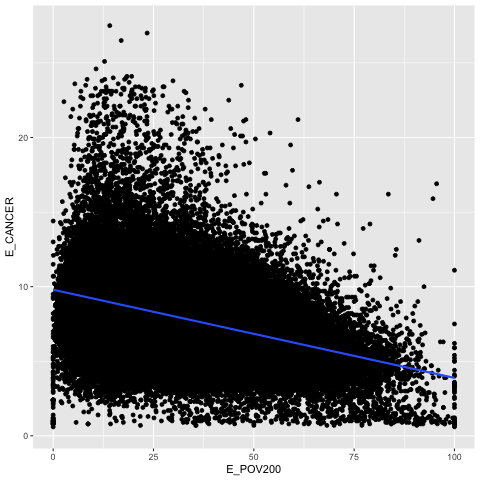

In [328]:
%%R

ggplot(df) +
    aes(x=E_POV200,  y=E_CANCER) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2422 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2422 rows containing missing values or values outside the scale range
(`geom_point()`). 



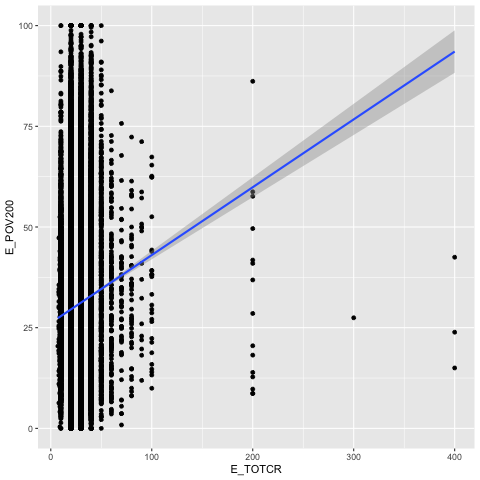

In [329]:
%%R

ggplot(df) +
    aes(x=E_TOTCR,  y=E_POV200) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)


`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2324 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2324 rows containing missing values or values outside the scale range
(`geom_point()`). 



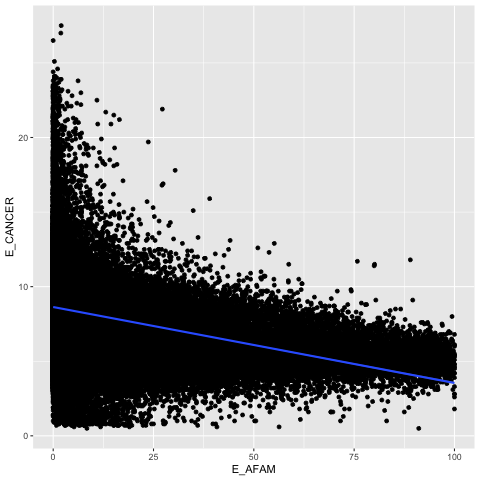

In [330]:
%%R

ggplot(df) +
    aes(x=E_AFAM,  y=E_CANCER) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1704 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 1704 rows containing missing values or values outside the scale range
(`geom_point()`). 



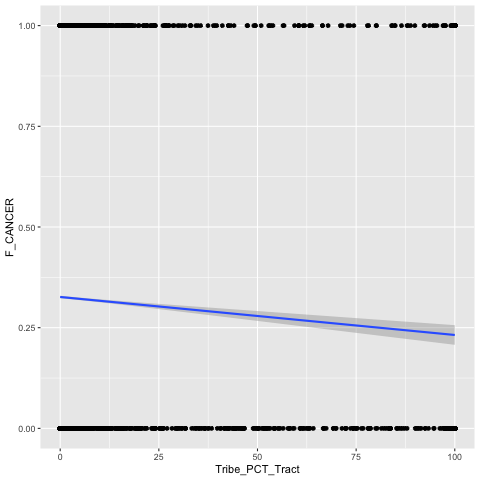

In [331]:
%%R

ggplot(df) +
    aes(x=Tribe_PCT_Tract,  y=F_CANCER) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

### This doesn't make total sense to me - appears actual cancer rates decline with increasing poverty, Black population, Native population. But the risk of developing cancer increases. Is it that overall among all rates of cancer, wealthier communities are diagnosed and treated with cancer more often? 

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2324 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2324 rows containing missing values or values outside the scale range
(`geom_point()`). 



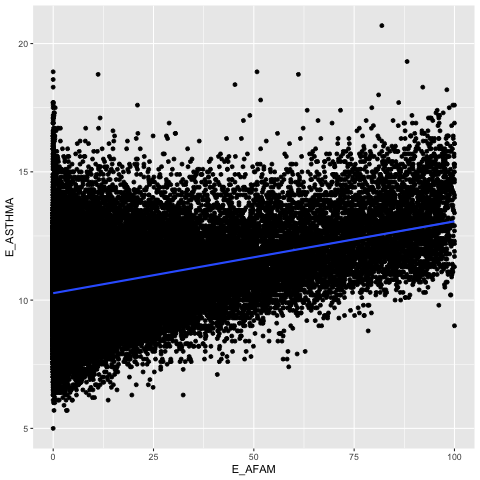

In [332]:
%%R

ggplot(df) +
    aes(x=E_AFAM,  y=E_ASTHMA) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2501 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2501 rows containing missing values or values outside the scale range
(`geom_point()`). 



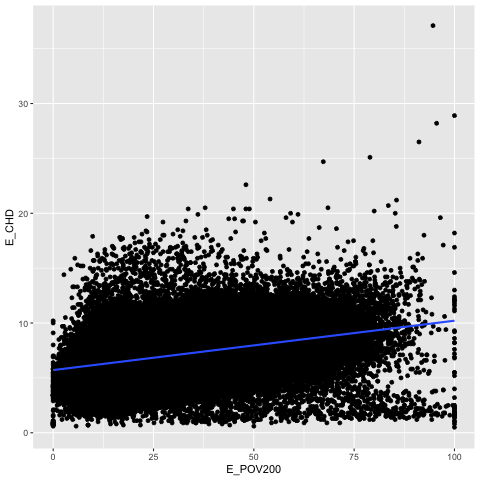

In [333]:
%%R

ggplot(df) +
    aes(x=E_POV200,  y=E_CHD) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2324 rows containing non-finite outside the scale range
(`stat_smooth()`). 

R[write to console]: 2: Removed 2324 rows containing missing values or values outside the scale range
(`geom_point()`). 



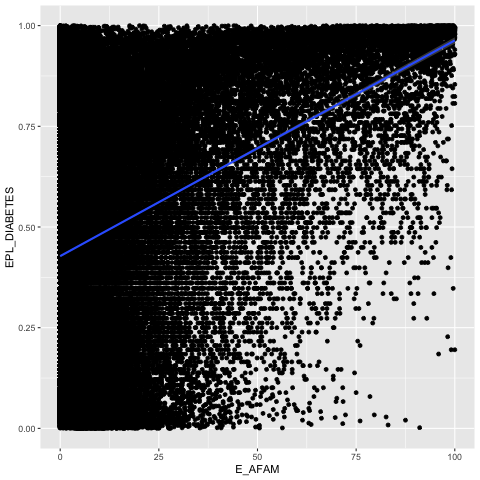

In [334]:
%%R

ggplot(df) +
    aes(x=E_AFAM,  y=EPL_DIABETES) +
    geom_point() +
    geom_smooth(method = "lm", se = TRUE)

In [335]:
df['E_CANCER'].max()

27.5

In [336]:
df[df['E_CANCER'] == 27.5]

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY_x,StateDesc,STATEABBR,LOCATION,...,latitude,STATE,COUNTY_y,TRACT,contains_energy_source,Technology_Category,Category_Number,fossil_fuels,renewables,energy_category_numeric
77011,51,59,431601,140000US51059431601,51059431601,51059431601,Fairfax County,Virginia,VA,Census Tract 4316.01; Fairfax County; Virginia,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0


In [337]:
df['E_CANCER'].min()

0.5

In [ ]:
#df['E_CANCER'].value_counts()

In [338]:
df[df['E_CANCER'] == 0.5]

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,GEOID_2020,COUNTY_x,StateDesc,STATEABBR,LOCATION,...,latitude,STATE,COUNTY_y,TRACT,contains_energy_source,Technology_Category,Category_Number,fossil_fuels,renewables,energy_category_numeric
82610,48,303,503,140000US48303000503,48303000503,48303000503,Lubbock County,Texas,TX,Census Tract 5.03; Lubbock County; Texas,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0
84582,48,473,980000,140000US48473980000,48473980000,48473980000,Waller County,Texas,TX,Census Tract 9800; Waller County; Texas,...,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0.0


In [339]:
%%R -i df
model <- lm(E_CANCER ~ factor(fossil_fuels) + E_POV200 + AFAM, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(fossil_fuels) + E_POV200 + AFAM, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6253 -1.5228  0.0438  1.3792 18.3294 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            9.867e+00  1.610e-02  612.80   <2e-16 ***
factor(fossil_fuels)1  6.696e-01  5.591e-02   11.98   <2e-16 ***
E_POV200              -4.682e-02  4.748e-04  -98.61   <2e-16 ***
AFAM                  -9.720e-04  1.066e-05  -91.22   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.348 on 85859 degrees of freedom
  (2501 observations deleted due to missingness)
Multiple R-squared:  0.228,	Adjusted R-squared:  0.2279 
F-statistic:  8451 on 3 and 85859 DF,  p-value: < 2.2e-16



In [340]:
%%R -i df
model <- lm(E_CANCER ~ factor(renewables) + E_POV200 + AFAM, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(renewables) + E_POV200 + AFAM, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1968 -1.5114  0.0309  1.3660 18.3679 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          9.829e+00  1.620e-02  606.71   <2e-16 ***
factor(renewables)1  6.871e-01  3.092e-02   22.22   <2e-16 ***
E_POV200            -4.684e-02  4.739e-04  -98.86   <2e-16 ***
AFAM                -9.646e-04  1.064e-05  -90.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.343 on 85859 degrees of freedom
  (2501 observations deleted due to missingness)
Multiple R-squared:  0.2311,	Adjusted R-squared:  0.2311 
F-statistic:  8602 on 3 and 85859 DF,  p-value: < 2.2e-16



In [341]:
%%R -i df
model <- lm(E_CANCER ~ factor(energy_category_numeric) + E_POV200, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(energy_category_numeric) + E_POV200, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7853 -1.6684 -0.0506  1.4449 18.6836 

Coefficients:
                                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                       9.6956220  0.0169749  571.173  < 2e-16 ***
factor(energy_category_numeric)1  0.8439201  0.0323044   26.124  < 2e-16 ***
factor(energy_category_numeric)2  0.8897035  0.0728477   12.213  < 2e-16 ***
factor(energy_category_numeric)3  0.7691261  0.1047497    7.343 2.11e-13 ***
factor(energy_category_numeric)4  1.1728474  0.2368073    4.953 7.33e-07 ***
factor(energy_category_numeric)5  0.9535978  0.0787308   12.112  < 2e-16 ***
E_POV200                         -0.0588973  0.0004749 -124.026  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.448 on 85856 degrees of freedom
  (2501 observations deleted due to missingness)
Multiple

In [342]:
%%R -i df
model <- lm(E_CANCER ~ factor(Category_Number) + E_POV200 + E_AFAM, data=df)
summary(model)


Call:
lm(formula = E_CANCER ~ factor(Category_Number) + E_POV200 + 
    E_AFAM, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1285 -1.5323  0.0442  1.3750 18.4975 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               9.6760403  0.0163253 592.702  < 2e-16 ***
factor(Category_Number)1  0.6400293  0.0389149  16.447  < 2e-16 ***
factor(Category_Number)2  0.7423444  0.0700658  10.595  < 2e-16 ***
factor(Category_Number)3  0.7923755  0.0790258  10.027  < 2e-16 ***
factor(Category_Number)4  0.8326343  0.0737863  11.284  < 2e-16 ***
factor(Category_Number)5  0.7988101  0.0728132  10.971  < 2e-16 ***
factor(Category_Number)6  0.6289739  0.1007313   6.244 4.28e-10 ***
factor(Category_Number)7  0.6495919  0.1266444   5.129 2.92e-07 ***
factor(Category_Number)8  0.9709389  0.2277037   4.264 2.01e-05 ***
factor(Category_Number)9  0.4834543  0.3676828   1.315    0.189    
E_POV200                 -0.0427288  0.0004958 -86.

### After controlling for poverty and African American percentage, cancer rates increase in tracts with all types of powerplants except nuclear - the highest in tracts with coal

In [343]:
%%R -i df
model <- lm(E_UNINSUR ~ factor(Category_Number) + E_POV200, data=df)
summary(model)


Call:
lm(formula = E_UNINSUR ~ factor(Category_Number) + E_POV200, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.241  -3.692  -1.270   2.570  97.480 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.520265   0.044968  56.045  < 2e-16 ***
factor(Category_Number)1 -0.301172   0.107312  -2.807  0.00501 ** 
factor(Category_Number)2 -0.484206   0.193225  -2.506  0.01222 *  
factor(Category_Number)3 -0.541965   0.217758  -2.489  0.01282 *  
factor(Category_Number)4 -0.320806   0.203543  -1.576  0.11500    
factor(Category_Number)5 -0.222311   0.200969  -1.106  0.26865    
factor(Category_Number)6 -0.268748   0.277832  -0.967  0.33340    
factor(Category_Number)7  0.007766   0.349641   0.022  0.98228    
factor(Category_Number)8 -1.380042   0.628662  -2.195  0.02815 *  
factor(Category_Number)9  0.472502   1.015164   0.465  0.64161    
E_POV200                  0.207205   0.001257 164.868  < 2e-16 ***
---

### After controlling for poverty rates, people living near power plants may be slightly more likely to be insured? Especially coal

In [344]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_UNINSUR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_UNINSUR, family = "binomial", 
    data = df)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -3.738898   0.036904 -101.315  < 2e-16 ***
E_UNINSUR   -0.011880   0.003441   -3.453 0.000555 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17559  on 86003  degrees of freedom
Residual deviance: 17546  on 86002  degrees of freedom
  (2360 observations deleted due to missingness)
AIC: 17550

Number of Fisher Scoring iterations: 6



In [345]:
%%R

PseudoR2(logistic, which="McFadden")

    McFadden 
0.0007141573 


In [346]:
%%R -i df
logistic <- glm(fossil_fuels ~ SPL_EBM_DOM1, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ SPL_EBM_DOM1, family = "binomial", 
    data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.65712    0.04092  -64.94   <2e-16 ***
SPL_EBM_DOM1 -0.96600    0.03464  -27.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17695  on 86503  degrees of freedom
Residual deviance: 16758  on 86502  degrees of freedom
  (1860 observations deleted due to missingness)
AIC: 16762

Number of Fisher Scoring iterations: 7



In [348]:
%%R -i df
logistic <- glm(fossil_fuels ~ SPL_EBM_DOM1, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ SPL_EBM_DOM1, family = "binomial", 
    data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.65712    0.04092  -64.94   <2e-16 ***
SPL_EBM_DOM1 -0.96600    0.03464  -27.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17695  on 86503  degrees of freedom
Residual deviance: 16758  on 86502  degrees of freedom
  (1860 observations deleted due to missingness)
AIC: 16762

Number of Fisher Scoring iterations: 7



In [349]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.05297082 


In [350]:
%%R

exp(coef(logistic))

 (Intercept) SPL_EBM_DOM1 
  0.07015031   0.38060396 


In [351]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_TOTCR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_TOTCR, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.145121   0.081375  -26.36   <2e-16 ***
E_TOTCR     -0.071892   0.003553  -20.23   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17695  on 86503  degrees of freedom
Residual deviance: 17257  on 86502  degrees of freedom
  (1860 observations deleted due to missingness)
AIC: 17261

Number of Fisher Scoring iterations: 7



In addition: Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 


In [352]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.02477451 


In [353]:
%%R -i df
logistic <- glm(renewables ~ E_TOTCR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = renewables ~ E_TOTCR, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.699549   0.046331   -15.1   <2e-16 ***
E_TOTCR     -0.078531   0.002014   -39.0   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44898  on 86503  degrees of freedom
Residual deviance: 43234  on 86502  degrees of freedom
  (1860 observations deleted due to missingness)
AIC: 43238

Number of Fisher Scoring iterations: 6



In addition: Warning message:
glm.fit: fitted probabilities numerically 0 or 1 occurred 


In [354]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.03704926 


In [355]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_UNINSUR + AFAM + E_IMPWTR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_UNINSUR + AFAM + E_IMPWTR, family = "binomial", 
    data = df)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.222e+00  4.780e-02 -67.412  < 2e-16 ***
E_UNINSUR   -1.329e-02  3.532e-03  -3.762 0.000168 ***
AFAM        -2.529e-04  4.116e-05  -6.144 8.04e-10 ***
E_IMPWTR    -9.266e-01  6.848e-02 -13.531  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17559  on 86003  degrees of freedom
Residual deviance: 17293  on 86000  degrees of freedom
  (2360 observations deleted due to missingness)
AIC: 17301

Number of Fisher Scoring iterations: 7



In [356]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.01510601 


In [357]:
%%R -i df
logistic <- glm(renewables ~ E_UNINSUR + AFAM + E_IMPWTR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = renewables ~ E_UNINSUR + AFAM + E_IMPWTR, family = "binomial", 
    data = df)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.937e+00  2.670e-02 -72.525  < 2e-16 ***
E_UNINSUR   -1.023e-02  1.915e-03  -5.342 9.19e-08 ***
AFAM        -2.475e-04  2.222e-05 -11.140  < 2e-16 ***
E_IMPWTR    -9.721e-01  3.792e-02 -25.635  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44639  on 86003  degrees of freedom
Residual deviance: 43729  on 86000  degrees of freedom
  (2360 observations deleted due to missingness)
AIC: 43737

Number of Fisher Scoring iterations: 5



In [358]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.02037194 


In [359]:
%%R -i df
logistic <- glm(renewables ~ E_CANCER + E_POV200 + E_UNINSUR + AFAM + E_UNEMP + E_DISABL + E_LIMENG, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = renewables ~ E_CANCER + E_POV200 + E_UNINSUR + 
    AFAM + E_UNEMP + E_DISABL + E_LIMENG, family = "binomial", 
    data = df)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.1199335  0.0676377 -46.127  < 2e-16 ***
E_CANCER     0.0654838  0.0063614  10.294  < 2e-16 ***
E_POV200     0.0081701  0.0011692   6.988 2.80e-12 ***
E_UNINSUR    0.0139406  0.0023196   6.010 1.86e-09 ***
AFAM        -0.0002079  0.0000239  -8.697  < 2e-16 ***
E_UNEMP     -0.0309980  0.0036621  -8.465  < 2e-16 ***
E_DISABL     0.0061788  0.0026325   2.347   0.0189 *  
E_LIMENG    -0.0618680  0.0036939 -16.749  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44555  on 85851  degrees of freedom
Residual deviance: 43441  on 85844  degrees of freedom
  (2512 observations deleted due to missingness)
AIC: 43457

Number of Fisher Scoring iterations: 6



In [360]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.02500464 


In [361]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_CANCER + E_POV200 + E_UNINSUR + AFAM + E_UNEMP + E_DISABL + E_LIMENG, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_CANCER + E_POV200 + E_UNINSUR + 
    AFAM + E_UNEMP + E_DISABL + E_LIMENG, family = "binomial", 
    data = df)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.348e+00  1.208e-01 -35.986  < 2e-16 ***
E_CANCER     6.084e-02  1.129e-02   5.388 7.12e-08 ***
E_POV200     8.571e-03  2.100e-03   4.082 4.47e-05 ***
E_UNINSUR    9.187e-03  4.242e-03   2.166   0.0303 *  
AFAM        -2.168e-04  4.412e-05  -4.913 8.96e-07 ***
E_UNEMP     -3.012e-02  6.628e-03  -4.544 5.51e-06 ***
E_DISABL     6.062e-03  4.697e-03   1.291   0.1968    
E_LIMENG    -6.300e-02  6.911e-03  -9.116  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17491  on 85851  degrees of freedom
Residual deviance: 17158  on 85844  degrees of freedom
  (2512 observations deleted due to missingness)
AIC: 17174

Number of Fisher Scoring iterations: 7



In [362]:
%%R

PseudoR2(logistic, which="McFadden")

  McFadden 
0.01904985 


In [363]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_POV200, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_POV200, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.765548   0.047121 -79.912   <2e-16 ***
E_POV200    -0.002502   0.001369  -1.828   0.0675 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17533  on 85948  degrees of freedom
Residual deviance: 17530  on 85947  degrees of freedom
  (2415 observations deleted due to missingness)
AIC: 17534

Number of Fisher Scoring iterations: 6



In [ ]:
%%R

PseudoR2(logistic, which="McFadden")

In [364]:
%%R -i df
logistic <- glm(renewables ~ E_UNINSUR, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = renewables ~ E_UNINSUR, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -2.478658   0.020430 -121.325  < 2e-16 ***
E_UNINSUR   -0.008540   0.001858   -4.596 4.32e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 44639  on 86003  degrees of freedom
Residual deviance: 44617  on 86002  degrees of freedom
  (2360 observations deleted due to missingness)
AIC: 44621

Number of Fisher Scoring iterations: 5



## Multinomial logistic regressions

In [365]:
%%R
# Load the package
library(nnet)

# Convert the outcome to a factor
df$Category_Number <- as.factor(df$Category_Number)

# Fit the multinomial logistic regression model
multi_logit <- multinom(Category_Number ~ E_POV200 + E_UNINSUR + AFAM + E_IMPWTR + E_UNEMP + E_CANCER, data = df)

# View the summary
summary(multi_logit)

# weights:  80 (63 variable)
initial  value 197681.535404 
iter  10 value 76409.305076
iter  20 value 67069.922082
iter  30 value 64689.010007
iter  40 value 62611.210500
iter  50 value 60878.237635
iter  60 value 50590.687739
iter  70 value 45579.857294
iter  80 value 44030.222851
iter  90 value 43786.383852
iter 100 value 43475.922686
final  value 43475.922686 
stopped after 100 iterations
Call:
multinom(formula = Category_Number ~ E_POV200 + E_UNINSUR + AFAM + 
    E_IMPWTR + E_UNEMP + E_CANCER, data = df)

Coefficients:
  (Intercept)    E_POV200    E_UNINSUR          AFAM   E_IMPWTR     E_UNEMP
1   -3.339476 0.007643649 -0.006788460 -8.759829e-05 -0.9287546 -0.03084403
2   -4.673176 0.008867602 -0.011091363 -1.522576e-04 -0.9150916 -0.02764146
3   -5.020057 0.012049773 -0.009882303 -2.117457e-04 -0.9669524 -0.02605804
4   -5.061382 0.010305209 -0.003244273 -1.805118e-04 -0.8501007 -0.02490647
5   -4.878917 0.008162888 -0.002782761 -1.456751e-04 -0.9726833 -0.02315543
6   -5.234183 

In [366]:
%%R

z <- summary(multi_logit)$coefficients / summary(multi_logit)$standard.errors
p <- 2 * (1 - pnorm(abs(z)))
p

  (Intercept)     E_POV200   E_UNINSUR         AFAM     E_IMPWTR      E_UNEMP
1           0 1.413491e-09 0.016389703 0.0017466082 0.000000e+00 2.983214e-11
2           0 1.069746e-04 0.034873661 0.0052870341 0.000000e+00 9.403008e-04
3           0 2.075675e-06 0.086933628 0.0009025625 0.000000e+00 4.681914e-03
4           0 1.740945e-05 0.540928356 0.0020940927 0.000000e+00 3.823431e-03
5           0 5.884740e-04 0.595312679 0.0093198847 0.000000e+00 6.349351e-03
6           0 2.323242e-02 0.105073855 0.3474003077 0.000000e+00 4.515119e-02
7           0 5.408106e-02 0.772126476 0.1473913781 8.720624e-11 2.177451e-02
8           0 6.265706e-01 0.000871592 0.6703948902 0.000000e+00 9.256241e-04
9           0 4.675079e-01 0.757256287 0.1486499274 0.000000e+00 5.253911e-01
      E_CANCER
1 0.000000e+00
2 0.000000e+00
3 0.000000e+00
4 0.000000e+00
5 0.000000e+00
6 0.000000e+00
7 8.881784e-16
8 0.000000e+00
9 1.160164e-02


In [367]:
%%R

odds_ratios <- exp(coef(multi_logit))

In [368]:
%%R
odds_ratios

   (Intercept) E_POV200 E_UNINSUR      AFAM   E_IMPWTR   E_UNEMP E_CANCER
1 0.0354555209 1.007673 0.9932345 0.9999124 0.39504539 0.9696268 1.098785
2 0.0093425508 1.008907 0.9889699 0.9998478 0.40047993 0.9727371 1.112839
3 0.0066041495 1.012123 0.9901664 0.9997883 0.38024009 0.9742785 1.117610
4 0.0063367935 1.010358 0.9967610 0.9998195 0.42737188 0.9754011 1.132239
5 0.0076052432 1.008196 0.9972211 0.9998543 0.37806722 0.9771106 1.124002
6 0.0053311786 1.007062 0.9882836 0.9999343 0.35244628 0.9767346 1.098479
7 0.0030676828 1.007487 1.0024477 0.9998660 0.40073112 0.9659103 1.098653
8 0.0013108014 1.003568 0.9280062 0.9999196 0.61638221 0.8989140 1.165137
9 0.0003656461 1.009897 0.9902850 1.0003019 0.03364019 0.9671960 1.097435


### E_POV200	Slight ↑ odds with poverty
E_UNINSUR	Mostly no effect
AFAM	No effect
E_IMPWTR	Strong ↓ odds
E_UNEMP	Slight ↓ odds
E_CANCER	Moderate ↑ odds

In [370]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_AIAN, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = fossil_fuels ~ E_AIAN, family = "binomial", data = df)

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -3.848662   0.023990 -160.430  < 2e-16 ***
E_AIAN       0.011487   0.003689    3.114  0.00185 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17588  on 86147  degrees of freedom
Residual deviance: 17580  on 86146  degrees of freedom
  (2216 observations deleted due to missingness)
AIC: 17584

Number of Fisher Scoring iterations: 6



In [371]:
%%R

PseudoR2(logistic, which="McFadden")

    McFadden 
0.0004307282 


In [ ]:
%%R -i df
logistic <- glm(fossil_fuels ~ E_AIAN, data=df, family="binomial")
summary(logistic)